<a href="https://colab.research.google.com/github/akalpit23/Explainable-techniques/blob/main/Assignment-5/Explainable_Techniques_Assignment_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #05



## Akalpit Dawkhar

### **Explainable Techniques**

### Overview

In [19]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "Explainable-techniques/Assignment-5/" # Change to your repo name
git_path = 'https://github.com/akalpit23/Explainable-techniques.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file'
!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'Assignment-5/'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

rm: cannot remove './sample_data': No such file or directory
fatal: destination path 'Explainable-techniques' already exists and is not an empty directory.
[Errno 2] No such file or directory: 'Explainable-techniques/Assignment-5/Assignment-5/'
/content
Explainable-techniques/  imagenet_classes.txt  sample_image.jpg


In [22]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 24.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39587 sha256=88b5cc02146ef37fcca1d8413cb6adc4337c8877e4279758b6c8199884ca3bfc
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


In [30]:
import pandas as pd
import numpy as np
import torch
import xgboost as xgb
import shap
import lime
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import cv2
from torchvision.transforms import Compose, ToTensor, Normalize
from lime import lime_image
from sklearn.model_selection import train_test_split
from anchor import anchor_tabular
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from PIL import Image
from skimage.segmentation import mark_boundaries
from alibi.explainers import AnchorImage
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.transforms import Compose, Normalize, ToTensor

In [6]:
!wget https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01532829_house_finch.JPEG -O /content/sample_image.jpg

!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt -O /content/imagenet_classes.txt

--2024-10-10 00:10:36--  https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01532829_house_finch.JPEG
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78014 (76K) [image/jpeg]
Saving to: ‘/content/sample_image.jpg’

/content/sample_ima 100%[===================>]  76.19K  --.-KB/s    in 0.02s   

2024-10-10 00:10:36 (3.40 MB/s) - ‘/content/sample_image.jpg’ saved [78014/78014]

--2024-10-10 00:10:36--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response...

In [3]:
# Load pre-trained ResNet34 model
model = models.resnet34(pretrained=True)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 85.1MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
# 3. Define image preprocessing steps (resize, normalize)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
# Load and preprocess the image
image_path = "sample_image.jpg"
image = Image.open(image_path).convert('RGB')
input_tensor = preprocess(image).unsqueeze(0)


In [8]:
input_tensor.shape

torch.Size([1, 3, 224, 224])

In [9]:
# 5. Predict with the model
output = model(input_tensor)
_, pred_class = torch.max(output, 1)

In [10]:
# 6. Define the LIME explainer
explainer = lime_image.LimeImageExplainer()

# 7. Function to predict the output of perturbed images for LIME
def predict_fn(images):
    batch = torch.stack([preprocess(Image.fromarray(img)) for img in images])
    output = model(batch)
    return output.detach().numpy()

In [11]:
# 8. Generate explanations for the prediction
explanation = explainer.explain_instance(np.array(image), predict_fn, top_labels=1, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

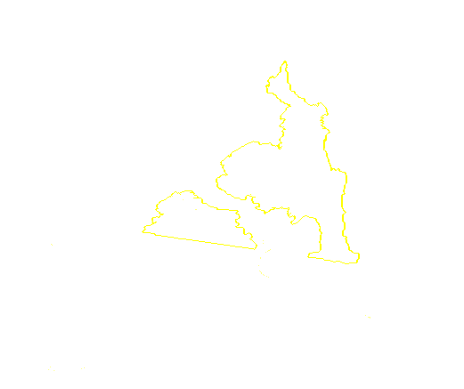

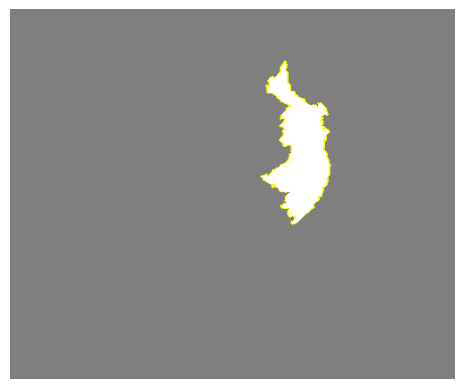

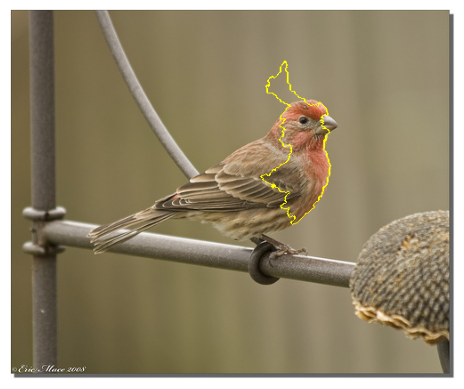

In [12]:
# 9. Visualize the explanation

# Get the top predicted label from the explanation
top_label = explanation.top_labels[0]

# First visualization: Show explanation with positive_only=False, num_features=10, hide_rest=False
temp, mask = explanation.get_image_and_mask(top_label, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))  # Visualize the mask on the image
plt.axis('off')
plt.show()

# Second visualization: Show explanation with positive_only=True, num_features=5, hide_rest=True
temp, mask = explanation.get_image_and_mask(top_label, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))  # Visualize the mask on the image
plt.axis('off')
plt.show()

# Original visualization: Show explanation with positive_only=True, num_features=5, hide_rest=False
temp, mask = explanation.get_image_and_mask(top_label, positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 255.0, mask))  # Visualize the mask on the image
plt.axis('off')
plt.show()

In [13]:
from torchvision import transforms

# Define your transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor(),  # Convert the image to PyTorch Tensor data type
    # Add any other transformations you need
])

pil_image = Image.open(image_path).convert("RGB")  # Load and convert image to RGB
image_tensor = transform(pil_image).unsqueeze(0)

In [14]:
def predict_anchor(images):
    batch = torch.stack([preprocess(Image.fromarray(img.astype(np.uint8))) for img in images])
    output = model(batch)
    return output.detach().numpy()  # Convert PyTorch tensor to numpy array

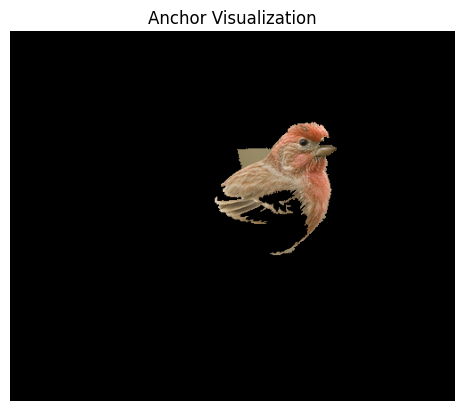

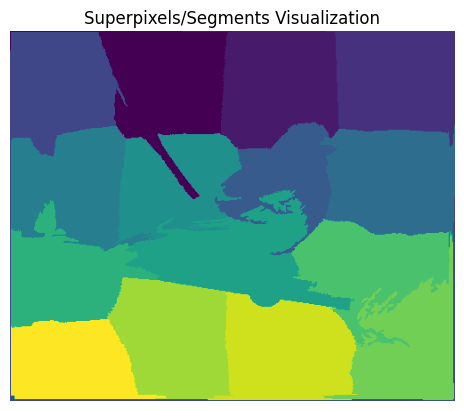

In [15]:
# Initialize the AnchorImage explainer
segmentation_fn = 'slic'
kwargs = {'n_segments': 15, 'compactness': 20, 'sigma': .5}  # Adjust segmentation parameters as needed
explainer = AnchorImage(predict_anchor, image_shape=(224, 224, 3), segmentation_fn=segmentation_fn,
                        segmentation_kwargs=kwargs)

# Explain the prediction for the input image (provide the image as a numpy array)
np_image = np.array(pil_image)
explanation = explainer.explain(np_image, threshold=0.95)

# Visualize the anchor
plt.imshow(explanation.anchor)
plt.title("Anchor Visualization")
plt.axis('off')  # Turn off axis
plt.show()

# Visualize the superpixels
plt.imshow(explanation.segments)
plt.title("Superpixels/Segments Visualization")
plt.axis('off')  # Turn off axis
plt.show()

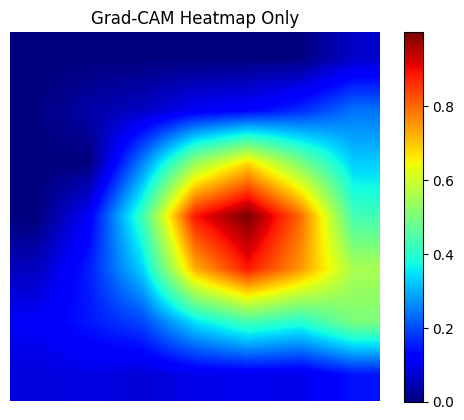

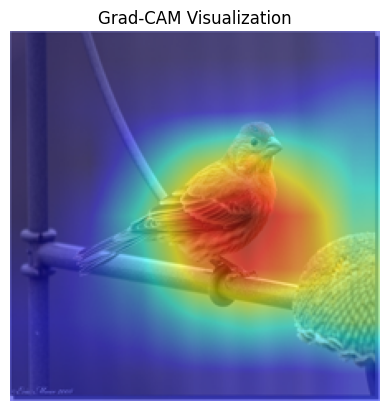

In [32]:
# 3. Grad-CAM

# Define target layers (usually the last convolutional layer)
target_layers = [model.layer4[-1]]

# Initialize the GradCAM explainer
cam = GradCAM(model=model, target_layers=target_layers)

# Define the target (e.g., class index 281 for 'tabby cat' in ImageNet)
targets = [ClassifierOutputTarget(281)]

# Generate the CAM
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# Resize the grayscale CAM to match the input image dimensions
grayscale_cam_resized = cv2.resize(grayscale_cam[0], (224, 224))

# Display only the Grad-CAM heatmap
plt.imshow(grayscale_cam_resized, cmap='jet')
plt.colorbar()
plt.axis('off')
plt.title('Grad-CAM Heatmap Only')
plt.show()

# Visualize the result
rgb_img = np.array(image.resize((224, 224)))
visualization = show_cam_on_image(rgb_img / 255.0, grayscale_cam_resized, use_rgb=True)

# Display the Grad-CAM visualization
plt.imshow(visualization)
plt.axis('off')
plt.title('Grad-CAM Visualization')
plt.show()